In [1]:
from sklearn.cluster import KMeans
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer


In [15]:
def read_and_SIFT(img_dir):
    image_list = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')]
    
    desc_list = []
    for image_file in image_list:

        image = cv2.imread(image_file)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        sift = cv2.SIFT_create()
        sift = cv2.xfeatures2d.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(gray_image, None)

        desc_list.append(descriptors)
    desc_arr = np.vstack(desc_list)
    return desc_arr, desc_list


def k_means_cluster(k,desc_array):
    max_iterations = 10 
    kmeans = KMeans(n_clusters=k, max_iter=max_iterations, random_state=0).fit(desc_array)
    visual_vocabulary = kmeans.cluster_centers_
    return visual_vocabulary

def get_bof_histogram(k, visual_vocabulary, descriptors_list):
    bof_histograms = []
    for descriptors in descriptors_list:
        distances = np.linalg.norm(descriptors[:, np.newaxis, :] - visual_vocabulary, axis=2)
        nearest_visual_word_indices = np.argmin(distances, axis=1)
        histogram, _ = np.histogram(nearest_visual_word_indices, bins=k, range=(0, k))
        bof_histograms.append(histogram)
    bof_histograms = np.array(bof_histograms)
    
    
    # Compute TF-IDF weights for BoW histograms
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(bof_histograms)

    # Return normalized BoW histograms with TF-IDF weights
    bof_histograms = tfidf.toarray()
    bof_histograms /= np.linalg.norm(bof_histograms, axis=1)[:, np.newaxis]
    return bof_histograms

    
    return bof_histograms

def get_bof_histogram2(k, visual_vocabulary, desc_list):
    # Compute BoW histograms for images using visual vocabulary
    histograms = []
    for desc in desc_list:
        histogram = np.zeros(k)
        words, counts = np.unique(desc, return_counts=True)
        for word, count in zip(words, counts):
            if word in visual_vocabulary:
                histogram[np.where(visual_vocabulary==word)[0]] += count
        histograms.append(histogram)

    # Compute TF-IDF weights for BoW histograms
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(histograms)

    # Return normalized BoW histograms with TF-IDF weights
    bof_histograms = tfidf.toarray()
    bof_histograms /= np.linalg.norm(bof_histograms, axis=1)[:, np.newaxis]
    return bof_histograms

def get_similar_images(N,query_image_file, visual_vocabulary, bof_histograms):
    query_image = cv2.imread(query_image_file)
    query_gray_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    query_keypoints, query_descriptors = sift.detectAndCompute(query_gray_image, None)
    distances = np.linalg.norm(query_descriptors[:, np.newaxis, :] - visual_vocabulary, axis=2)
    nearest_visual_word_indices = np.argmin(distances, axis=1)
    query_histogram, _ = np.histogram(nearest_visual_word_indices, bins=k, range=(0, k))


    similarities = []
    for histogram in bof_histograms:
        similarity = np.dot(query_histogram, histogram) / (np.linalg.norm(query_histogram) * np.linalg.norm(histogram))
        similarities.append(similarity)
    similarities = np.array(similarities)

    image_list = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')]

    top_indices = similarities.argsort()[::-1][:N]
    top_image_files = [image_list[i] for i in top_indices]

    return top_image_files

In [3]:
image_dir = os.getcwd()+'/pokemon'
image_list = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')]


In [4]:
desc_arr, desc_list = read_and_SIFT(image_dir)

[ WARN:0@1.965] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect s

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [24]:
from scipy.cluster.vq import kmeans
"""
K degeri belirlenirken 0-200 e kadar yeterli olmadigi gozlemlenmistir.
K 250'nin uzerine ciktiginda fotograflarin eslesmeye basladigi
gorulmustur. Bu deger 1000-2000 seviyelerine ciktiginda bazi
fotogtaflarin cok iyi benzerlik tespitini yapsa da hala istenilen
bazi fotograflari bulamadigi gorulmusutur. Ayni sekilde calisma
zamaninin cok fazla artmasi nedeniyle bu sayinin 350-450 arasinda
tutulmasi hem zaman hemde benzerlik bulma performansina uygun gorulmustur.


Iterasyon sayisinin 10-20 seviyelerinde olmasi fotograf
eslestirmede basarili sonuc verdigi gozlemlenmistir. Bu deger 30+
ustune ciktiginda performansa artik cok fazla etki etmemekte, programin
calisma suresini uzatmaktadir.

"""
k = 375
iters = 15
visual_vocabulary, variance = kmeans(desc_arr, k, iters)

In [25]:
bof_histograms = get_bof_histogram(k, visual_vocabulary, desc_list)

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/77.png


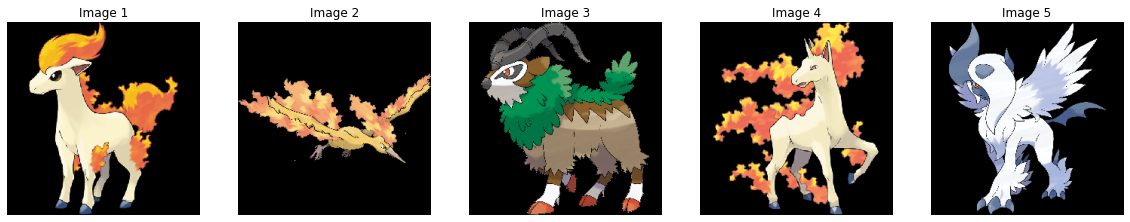

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/599.png


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


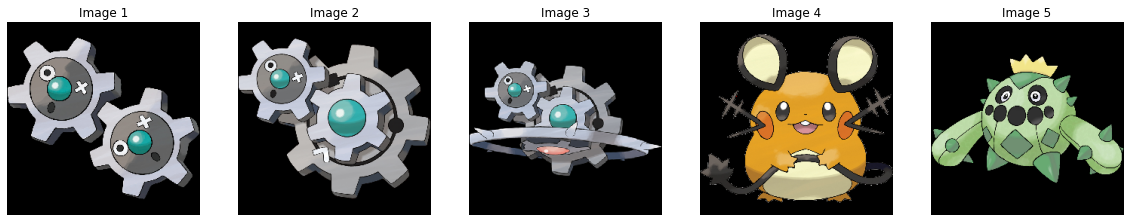

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/4.png


libpng warning: iCCP: known incorrect sRGB profile


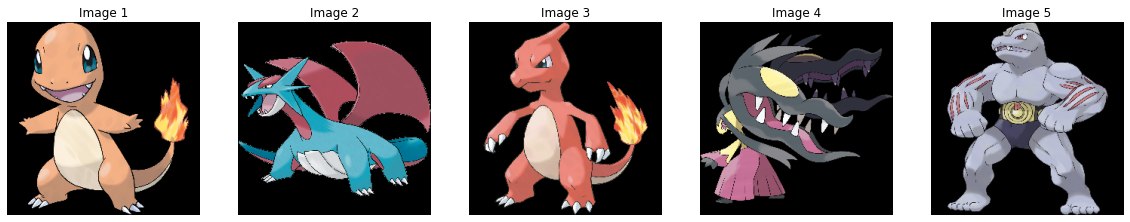

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/586-winter.png


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


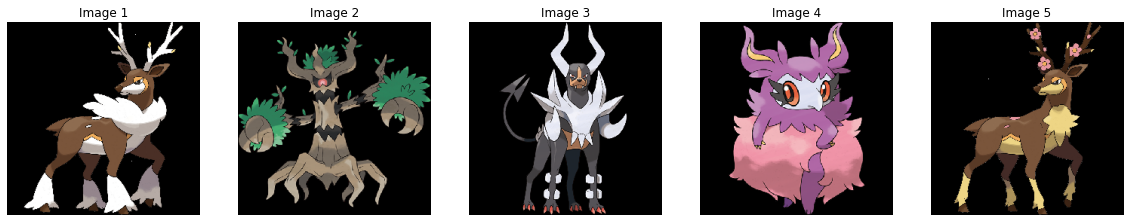

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/585-summer.png


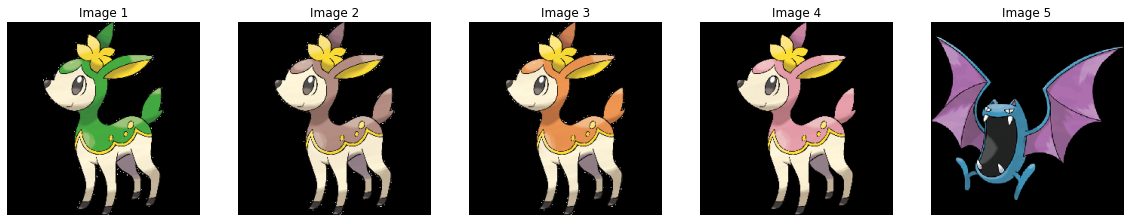

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/3.png


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


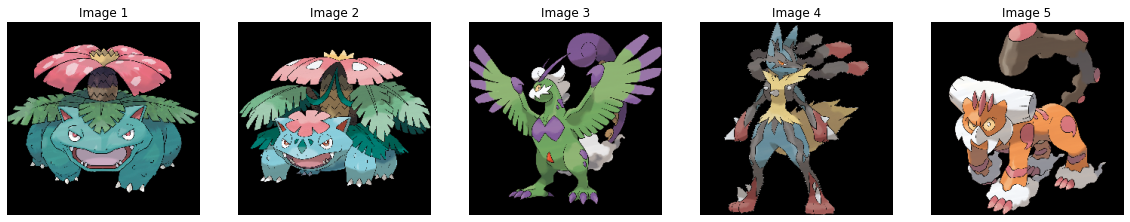

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/586-spring.png


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


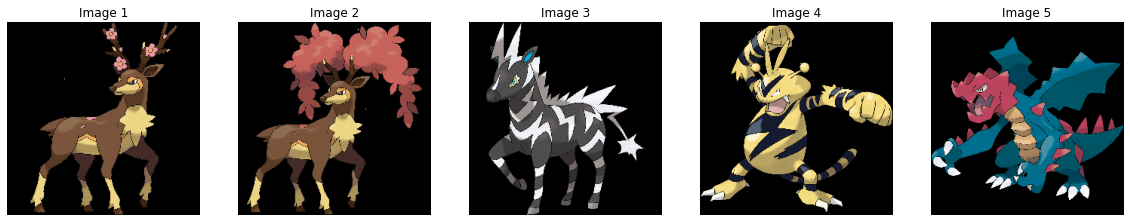

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/333.png


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


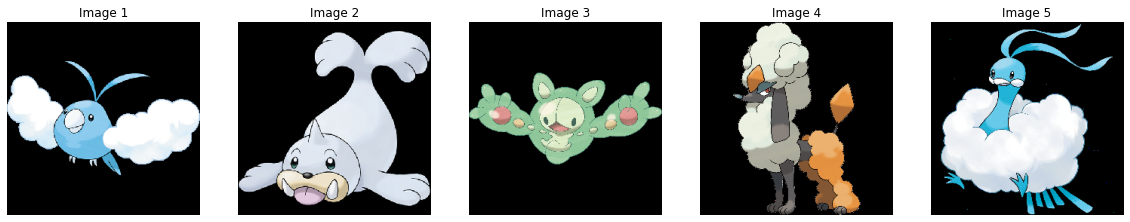

libpng warning: iCCP: known incorrect sRGB profile


Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/681.png


libpng warning: iCCP: known incorrect sRGB profile


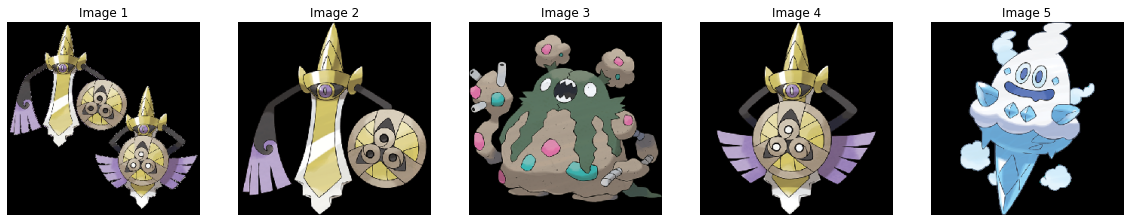

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/681-blade.png


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


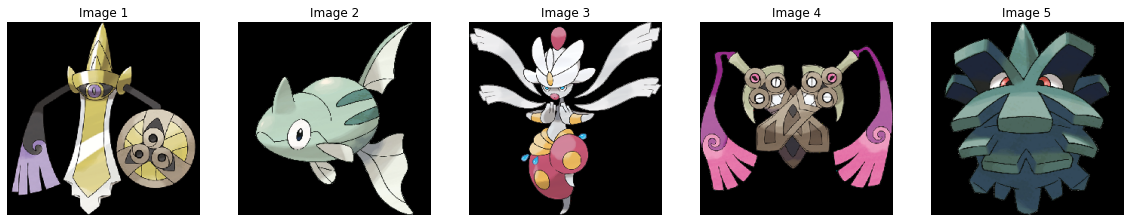

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/412-plant.png


libpng warning: iCCP: known incorrect sRGB profile


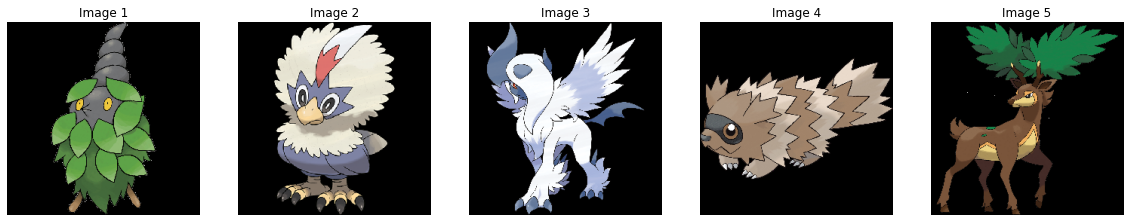

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/60.png


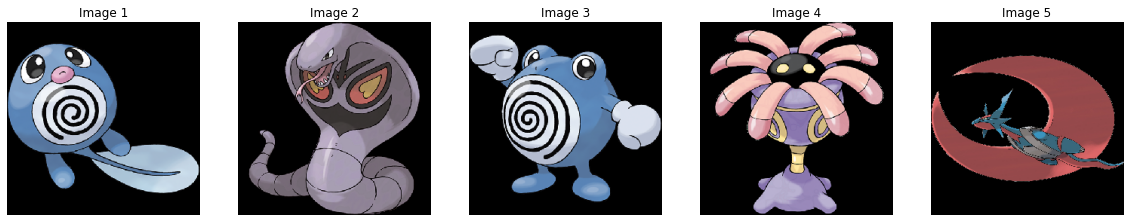

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/592.png


libpng warning: iCCP: known incorrect sRGB profile


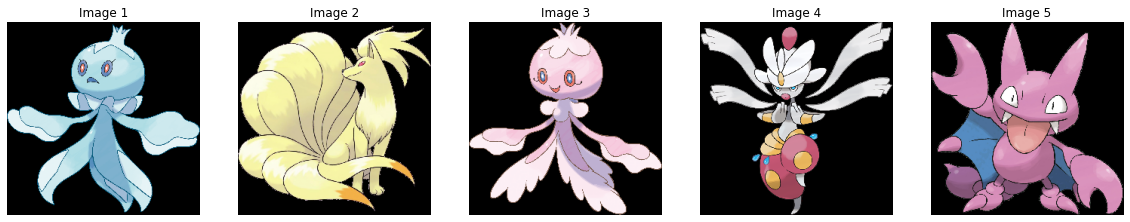

libpng warning: iCCP: known incorrect sRGB profile


Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/577.png


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


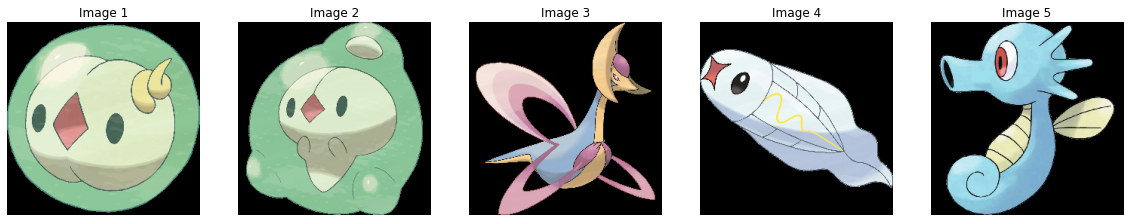

Similar results for: /home/erdem/Desktop/bil468/ErdemAkyuz_midterm/asd/41.png


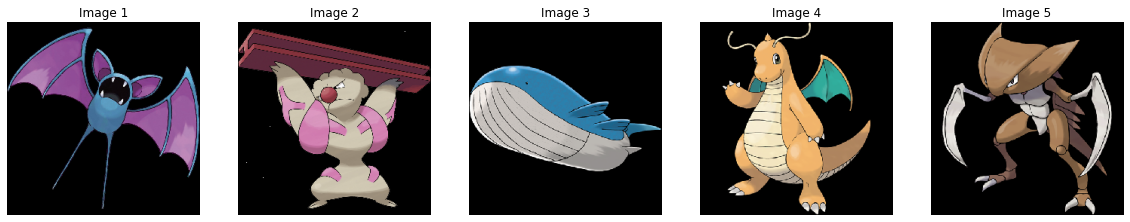

In [26]:
query_dir = os.getcwd()+'/query'
query_list = [os.path.join(query_dir, file) for file in os.listdir(query_dir) if file.endswith('.png')]
#query_list = sorted(query_list)
for query_img in query_list:
    img_name = query_img.replace(os.getcwd()+'/query/','')
    print("Similar results for: "+ img_name)
    N = 5
    top_image_files = get_similar_images(N, query_img, visual_vocabulary, bof_histograms)
    fig, axes = plt.subplots(1, N, figsize=(20, 20))
    for i, image_file in enumerate(top_image_files):
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis('off')
    plt.show() 

In [8]:
#k = 300
#visual_vocabulary = k_means_cluster(k, desc_arr)
# perform k-means clustering to build the codebook
